# 示例：量子整数因子分解

寻找整数因子分解的新方法在现代信息安全中发挥着重要作用。Shor算法可能是最为人熟知的整数因子分解方法。同样强大的量子计算模型是绝热量子计算（AQC）模型，它也可以解决整数因子分解问题。在这个示例中，我们将演示如何将任意整数因子分解问题转换为可执行的Ising模型，并在Dynex Neuromorphic Platform上进行测试。

##  将因子分解视为约束满足问题

经典整数因子分解的复杂度类别被认为介于P和NP困难之间。尽管研究已经提出了比直观的试除法更快的算法，包括费马算法、波拉德的两个算法和筛选算法，但经典算法是否存在能够在多项式时间内进行因子分解仍然是一个未决问题。对于量子计算，Shor算法在多项式时间内运行（D-Wave量子计算机不运行该算法，Dynex神经形态计算平台也尚未运行该算法）。

这个笔记本通过将整数因子分解问题转化为约束满足问题来解决了在Dynex神经形态平台上的因子分解问题。CSPs要求将问题的所有变量分配给值，以满足所有的约束。对于因子分解问题，约束是两个表示因子的变量a和b只能被分配为自然数，并且它们的乘积等于待分解的数字P。

在CSP中，有一些难题非常适合在量子计算机上解决。例如，地图着色问题是要对地图上的所有区域进行着色，以使任何两个共享边界的区域具有不同的颜色。作业车间调度问题是要安排多个作业在多台机器上执行，同时考虑机器执行任务的约束。您可以将此处所示的解决方法应用于许多CSPs。

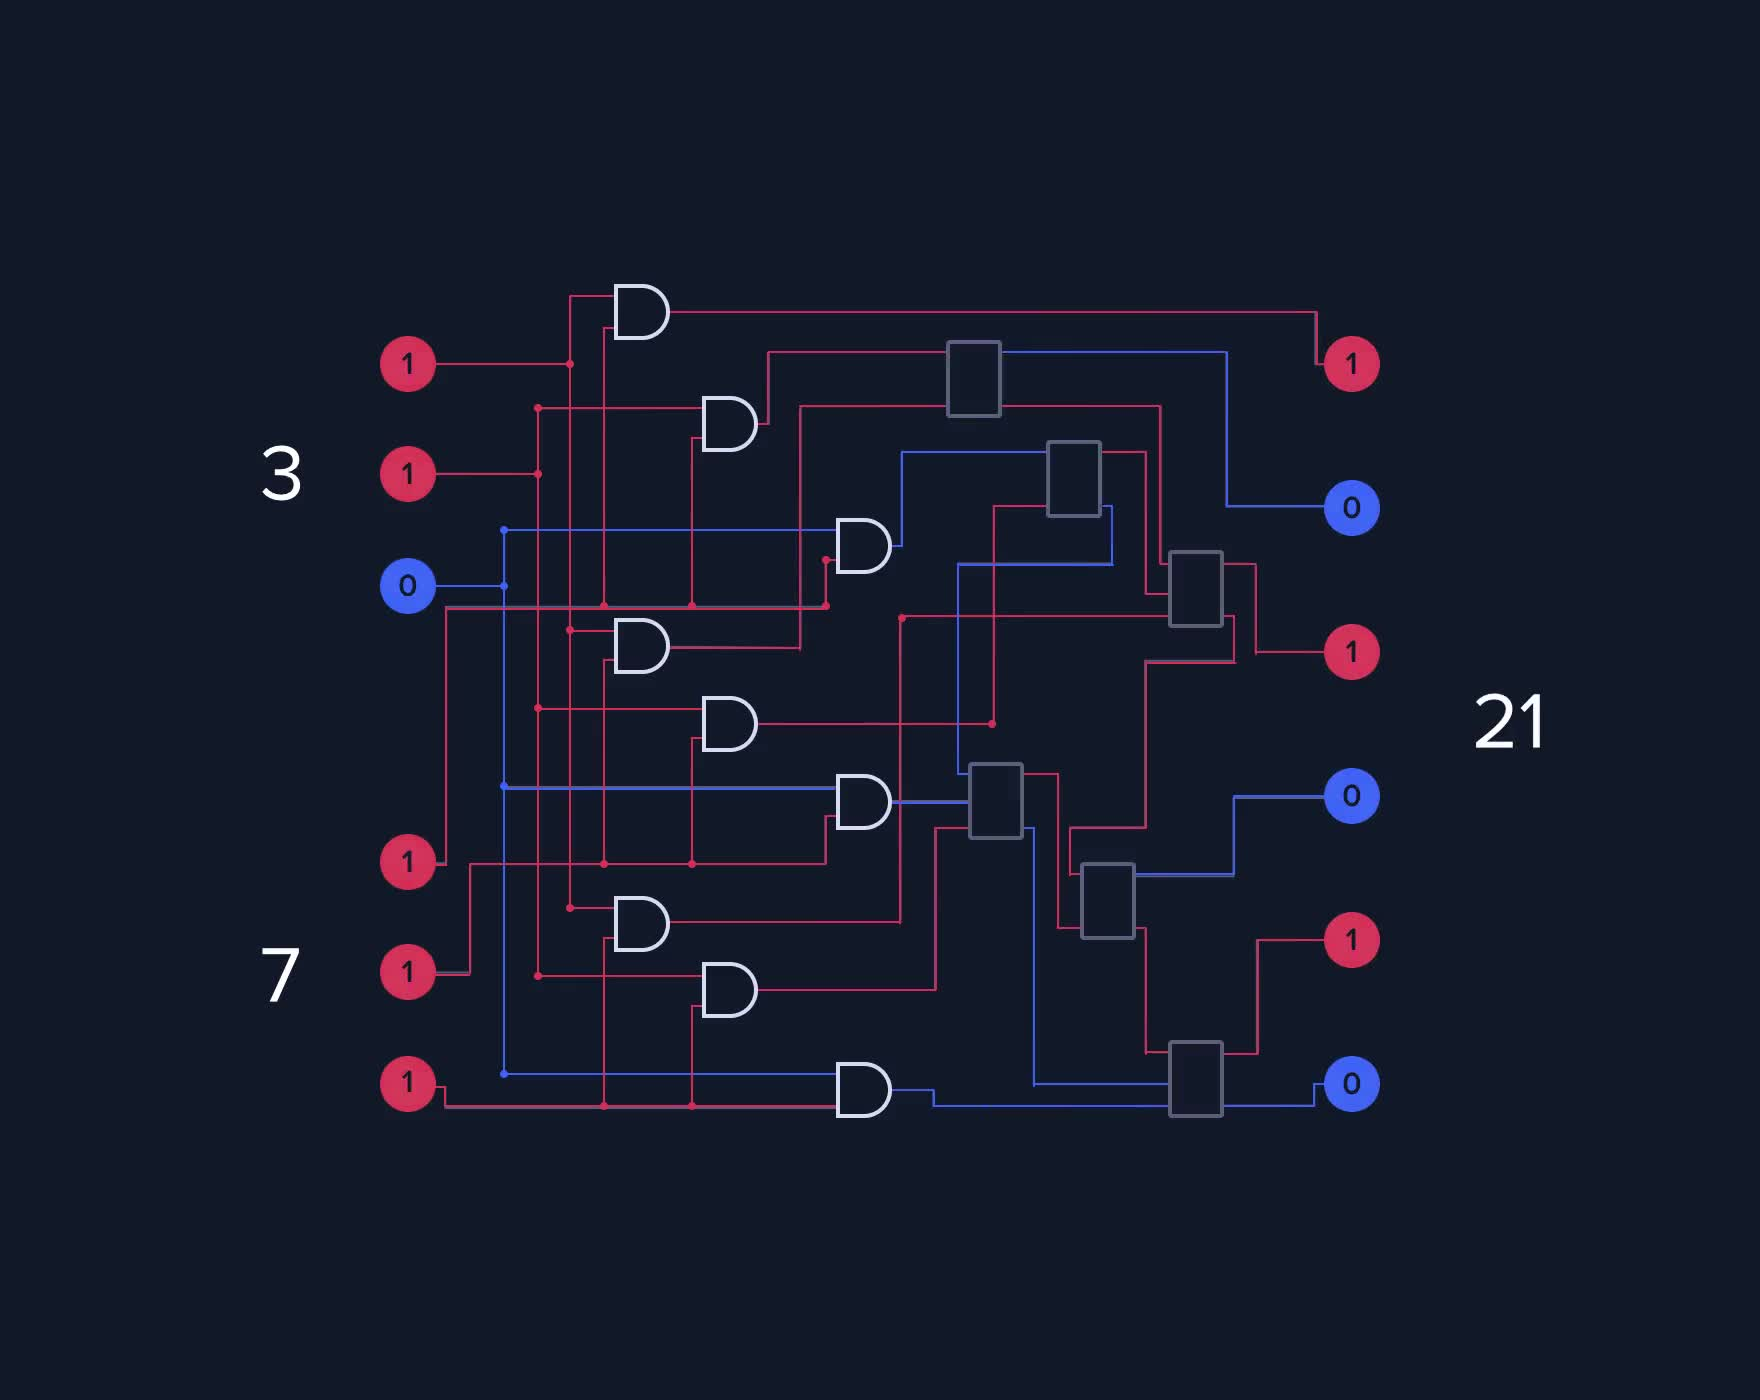

## 在Dynex神经形态计算平台上制定问题 

您如何制定因子分解问题，以便量子/神经形态计算机能够理解呢？

Dynex平台解决二元二次模型（BQM），这是在统计力学中传统上使用的Ising模型以及其计算机科学等效形式，即二次无约束二进制优化（QUBO）问题。考虑到N个变量x1,....,xn，其中每个变量xi可以取二进制值0或1，神经形态平台找到了最小化QUBO的值分配。

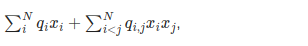

其中qi和qi,j是可配置的（线性和二次）系数。为了为Dynex平台制定问题，需要编程qi和qi,j，以便x1,....,xn的赋值也表示问题的解。

## 步骤1：将因子分解表示为乘法电路。

我们首先使用布尔逻辑门来表示问题，这种情况下是一个乘法电路。

该示例对表示为8位二进制数的整数196进行因数分解。为了在布尔逻辑中表示因式分解方程，使用一个简单的4位乘法器（一个接受两个4位二进制数并输出它们的8位二进制积的电路）。

注意：二进制乘法器是使用像上面使用的AND门之类的逻辑门制作的。理解因式分解示例及其应用于解决CSPs并不需要理解二进制乘法。

我们首先加载Dynex SDK和所需的库：

In [1]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import dynex
import dimod
from dimod.generators import multiplication_circuit

接下来，我们定义我们要分解的整数，并将其转换为其8位二进制表示：

In [3]:
P = 196 
bP = "{:8b}".format(P);    
print(P,' =  binary ',bP);

196  =  binary  11000100


## 步骤 2: 转换为二元二次模型（BQM）

将乘法电路表示为提供用于在Dynex平台上编程问题的系数的BQM。

In [4]:
bqm = multiplication_circuit(4);
print("BQM has {} variables".format(len(bqm.variables)));

BQM has 48 variables


Dynex Neuromorphic平台通过反向运行乘法电路来分解这个整数。在下面，将乘法电路的BQM的变量固定为已知的数字P的二进制位（由二进制变量P0、P1...P6表示）。这样可以通过移除已知变量并相应更新相邻的值来修改BQM。

In [5]:
p_vars = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']

# Convert P from decimal to binary
fixed_variables = dict(zip(reversed(p_vars), "{:08b}".format(P)))
fixed_variables = {var: int(x) for(var, x) in fixed_variables.items()}
print('Fixing target variables:',fixed_variables,P)

# Fix product variables
for var, value in fixed_variables.items():
    bqm.fix_variable(var, value)
    
print("BQM has {} non-fixed variables".format(len(bqm.variables)))

Fixing target variables: {'p7': 1, 'p6': 1, 'p5': 0, 'p4': 0, 'p3': 0, 'p2': 1, 'p1': 0, 'p0': 0} 196
BQM has 40 non-fixed variables


## 步骤3：提交至Dynex平台

最后，通过找到产生其最低值的变量分配来解决BQM。在这里，我们使用Dynex Neuromorphic平台：

In [36]:
dnxmodel = dynex.BQM(bqm, logging=True);

dnxsampler = dynex.DynexSampler(dnxmodel,  mainnet=True, description='INT_Factorisation_By_Rumony')

[DYNEX] MODEL CONVERTED TO QUBO
[DYNEX] PRECISION SET TO 0.0001
[DYNEX] QUBO: Constant offset of the binary quadratic model: 10.0
[DYNEX] SAMPLER INITIALISED


In [44]:
# Dynex 采样:
sampleset = dnxsampler.sample(num_reads=20000, annealing_time = 300, debugging=False, gamma=0.5, delta=0.5);
print('sample:',sampleset.first);
print('energy:',sampleset.lowest().record[0].energy);

[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬───────────┬───────────────────────────┬─────────┬─────┬─────────┬───────┬─────┬──────────┬─────╮
│ DYNEXJOB   │ ELAPSED   │ WORKERS                   │ CHIPS   │ ✔   │ STEPS   │ LOC   │ ✔   │ ENERGY   │ ✔   │
├────────────┼───────────┼───────────────────────────┼─────────┼─────┼─────────┼───────┼─────┼──────────┼─────┤
│            │           │ *** WAITING FOR READS *** │         │     │         │       │     │          │     │
╰────────────┴───────────┴───────────────────────────┴─────────┴─────┴─────────┴───────┴─────┴──────────┴─────╯

[DYNEX] FINISHED READ AFTER 0.00 SECONDS
[DYNEX] SAMPLESET LOADED
sample: Sample(sample={'a0': 0, 'a1': 1, 'a2': 1, 'a3': 1, 'and0,1': 0, 'and0,2': 0, 'and0,3': 1, 'and1,0': 0, 'and1,1': 1, 'and1,2': 1, 'and1,3': 1, 'and2,0': 0, 'and2,1': 1, 'and2,2': 1, 'and2,3': 1, 'and3,0': 0, 'and3,1': 1, 'and3,2': 1, 'and3,3': 1, 'b0': 0, 'b1': 1, 'b2': 1, 'b3': 1, 'carry1,0': 0, 'carry1,1': 0, 'carry1,2':

当Dynex平台解决问题时，它利用长程秩序和瞬子行为等现象同时探索所有可能的解，并找到一组最佳解。由于采样解是概率性的，因此不同运行之间返回的解可能会有所不同。通常，当向Dynex平台提交问题时，您会要求获取多个样本，而不仅仅是一个。这样，您可以看到多个答案，并降低定位到次优答案的概率。

## 查看解决方案

将二进制数字转换回整数。由于神经形态计算是概率性的，如果没有在足够多的Dynex芯片上运行，可能会在许多执行此示例的情况下返回一个不正确的解决方案。重新运行前面的单元格很可能会产生正确的答案。

In [45]:
def to_base_ten(sample):
    a = b = 0
    
    # 我们知道multiplication_circuit()函数已经创建了这些变量。
    a_vars = ['a0', 'a1', 'a2','a3']
    b_vars = ['b0', 'b1', 'b2','b3']
    
    for lbl in reversed(a_vars):
        a = (a << 1) | int(sample[lbl])
    for lbl in reversed(b_vars):
        b = (b << 1) | int(sample[lbl])
        
    return a,b

In [46]:
a, b = to_base_ten(dnxsampler.dimod_assignments.first.sample);
print(a,'x',b,'=',a*b)

14 x 14 = 196


正如我们所看到的，Dynex平台将196正确分解为14和14。

参考文献:
[1] Jiang, S., Britt, K.A., McCaskey, A.J.等人。《量子退火用于质因数分解》。《科学报告》（Sci Rep），第8卷，17667页（2018年）。https://doi.org/10.1038/s41598-018-36058-z。